# 3章Policy Function Iteration

### 0. 準備

In [68]:
# ライブラリのインポート
import numpy as np
from collections.abc import Callable
from scipy.optimize import fmin

In [69]:
# 使用する関数の定義
def output(k, A, alpha):
    return A * (k ** alpha)
def wealth(k: float, 
            A:float, 
            alpha: float, 
            delta: float,
            output: Callable[[float, float, float], float]):
    return output(k, A, alpha) + (1 - delta) * k
def utility(c: float, gamma: float):
    if gamma == 1:
        return np.log(c)
    else: 
        return (c ** (1 - gamma)) / (1 - gamma)

# 価値関数のグリッドを計算する関数
def calc_vf_new(k_grid, kprime_grid, A, P, alpha, delta, output, gamma, beta, vf_old): 
    vf_new = np.zeros((k_grid.size, A.size))
    for i, K in enumerate(k_grid):
        for l, a in enumerate(A):
            for k in range(len(A)):
                vf_new[i, l] += P[l, k] * (utility(wealth(K, a, alpha, delta, output) - kprime_grid[i, k], gamma) + beta * vf_old[i, k])
    return vf_new

# 価値関数の補間する関数
def vf_interp(k_grid, A, vf_grid): 
    def vf(k, a):
        A_index = np.where(A == a)[0][0]
        cheb_fit = np.polynomial.Chebyshev.fit(k_grid, vf_grid[:, A_index], deg = 16)
        return cheb_fit(k)
    return vf

# ベルマン方程式の右辺
def rhs_bellman(kprime_star, k ,a, alpha, beta, gamma, delta, # 変数とパラメータ
                utility, output, wealth, vf): # 必要な関数
    rhs = utility(wealth(k, a, alpha, delta, output) - kprime_star,
                gamma) + beta * vf(kprime_star, a)
    return - rhs

### 1. グリッド生成

In [70]:
nk = 21
k_grid = np.linspace(0.025, 0.5, 21)
print(k_grid)

[0.025   0.04875 0.0725  0.09625 0.12    0.14375 0.1675  0.19125 0.215
 0.23875 0.2625  0.28625 0.31    0.33375 0.3575  0.38125 0.405   0.42875
 0.4525  0.47625 0.5    ]


### 2. カリブレーションしたパラメータの値を設定

In [71]:
beta = 0.96
gamma = 1.0
alpha = 0.4
delta = 1.0

### 3. 収束の基準を与える

In [72]:
epsilon = 1e-5

### 4. 確率変数 $A = \{A_{good}, A_{bad}\}$を定義

In [73]:
A = np.array([1.01, 0.99])
print(A)

[1.01 0.99]


### 5. 遷移確率行列 $P$を定義

In [74]:
P = np.array([[0.875, 0.125], [0.125, 0.875]])
print(P)

[[0.875 0.125]
 [0.125 0.875]]


### 6. 政策関数の初期値をguess

- 今回は富の関数の半分の値とする

In [75]:
kprime_grid = np.zeros((k_grid.size, A.size))
for i, k in enumerate(k_grid):
    for l, a in enumerate(A):
        kprime_grid[i, l] = wealth(k, a, alpha, delta, output) /2
print(kprime_grid)

[[0.11546953 0.113183  ]
 [0.15082774 0.14784105]
 [0.17677733 0.17327679]
 [0.19799384 0.19407317]
 [0.21625386 0.21197161]
 [0.23245266 0.22784964]
 [0.24711397 0.24222063]
 [0.26057453 0.25541463]
 [0.27306546 0.26765822]
 [0.28475328 0.2791146 ]
 [0.2957625  0.28990581]
 [0.30618899 0.30012585]
 [0.31610841 0.30984884]
 [0.32558163 0.31913447]
 [0.33465845 0.32803155]
 [0.34338026 0.33658065]
 [0.35178182 0.34481584]
 [0.35989269 0.35276611]
 [0.36773826 0.36045631]
 [0.37534045 0.36790797]
 [0.38271843 0.37513985]]


### 7. 当て推量した政策関数を用いて価値関数を計算する

In [76]:
# a. 初期の価値関数をguess
vf_old = np.zeros((k_grid.size, A.size))
diff = 1.0 + epsilon
iter_count = 0
pf_kprime_grid = np.copy(kprime_grid)

while diff > epsilon:
    iter_count += 1

    # 7b. 新たな価値観数を得る
    for loop in range(1000):
        vf_new = calc_vf_new(k_grid, pf_kprime_grid, A, P, alpha, delta, output, gamma, beta, vf_old)
        vf_old = vf_new.copy()
    
    # 8 得られた新しい価値関数を用いて政策関数を求める
    vf = vf_interp(k_grid, A, vf_new) # 価値関数の補間
    
    
    for i, k in enumerate(k_grid): # 政策関数を求める
        for l, a in enumerate(A):
            pf_kprime_grid[i, l] = fmin(rhs_bellman, 
                                    x0 = k_grid[i], 
                                    args = (k, a, alpha, beta, gamma, delta,
                                            utility, output, wealth, vf), 
                                    disp = 0)[0]

    # 新しい政策関数を使って新しい価値関数を計算
    vf_new = calc_vf_new(k_grid, pf_kprime_grid, A, P, alpha, delta, output, gamma, beta, vf_old)

    diff = np.max(np.abs(vf_old - vf_new)) # 収束の判定
    vf_old = vf_new.copy()
    if iter_count%1 == 0:
        print(f'iteration: {iter_count}, diff: {diff}')
        print(vf_old[0])

/var/folders/y2/hwl07kg14b31nb5s126cjc8m0000gn/T/ipykernel_33468/276007681.py:12: RuntimeWarning: invalid value encountered in log
  return np.log(c)


iteration: 1, diff: 1.6966156481626982
[-55.82320778 -55.95620379]
iteration: 2, diff: nan
[-49.50755016 -49.68421503]


### p78 図3.6の価値関数と政策関数をプロット

[[0.11546953 0.113183  ]
 [0.15082774 0.14784105]
 [0.17677733 0.17327679]
 [0.19799384 0.19407317]
 [0.21625386 0.21197161]
 [0.23245266 0.22784964]
 [0.24711397 0.24222063]
 [0.26057453 0.25541463]
 [0.27306546 0.26765822]
 [0.28475328 0.2791146 ]
 [0.2957625  0.28990581]
 [0.30618899 0.30012585]
 [0.31610841 0.30984884]
 [0.32558163 0.31913447]
 [0.33465845 0.32803155]
 [0.34338026 0.33658065]
 [0.35178182 0.34481584]
 [0.35989269 0.35276611]
 [0.36773826 0.36045631]
 [0.37534045 0.36790797]
 [0.38271843 0.37513985]]


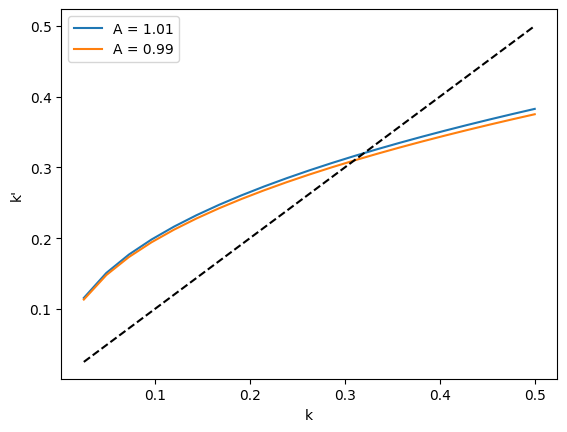

In [79]:
print(kprime_grid)
# k_grid と kprime_grid をプロット
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
for l, a in enumerate(A):
    ax.plot(k_grid, kprime_grid[:, l], label = f"A = {a}")
ax.plot(k_grid, k_grid, linestyle = "--", color = "k")
ax.set_xlabel("k")
ax.set_ylabel("k'")
ax.legend()
plt.show()

In [67]:
%reset -f

In [ ]:
iter_count

### iterationが収束しなかった原因

- 価値関数の添字を kではなくlにしていた